Install required packages

In [ ]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3
import matplotlib.pyplot as plt
plt.subplot()

In [ ]:
%%capture
%pip install scanpy
%pip install scvi-tools==0.8.1
%pip install loompy
%pip install leidenalg

In [ ]:
import torch 
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# System
import os, pathlib, time, gc

# Math
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold

# Plots
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# scvi
import anndata
import scvi
import torch

import os


#from scvi.distributions import NegativeBinomial

In [ ]:
import pdb

In [ ]:
%cd /content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI/
!ls

/content/drive/MyDrive/scBIVI_mc/scBIVI/scBIVI
 analysis.py		 run.sh
 Analysis_scBIVI.ipynb	 scBIVI-10-combined-4-train-history.pdf
 bivae.py		'scBIVI (1).ipynb'
 data			 scBIVI-3-combined-4-train-history.pdf
 data_expanded		 scBIVI-6-combined-4-train-history.pdf
 distribution_2.py	 scBIVIcustom-10-combined-4-train-history.pdf
 distribution.py	 scBIVIcustom-3-combined-4-train-history.pdf
 distribution_uni.py	 scBIVIcustom-6-combined-4-train-history.pdf
 download_data.sh	 scBIVI.ipynb
 experiment_colab.py	 scBIVI.py
 gena_snippets		 scBIVIuncorr-10-combined-4-train-history.pdf
 out			 scBIVIuncorr-3-combined-4-train-history.pdf
 preprocess.py		 scBIVIuncorr-6-combined-4-train-history.pdf
 __pycache__		 scUNIVI.ipynb
 README.txt		 scUNIVI.py
 requirements.txt	 umap_6z_corr.svg
 run_scBIVI.py		 univae.py


In [ ]:
# scbivi
from scBIVI import scBIVI
from analysis import calculate_accuracy, \
                     plot_corr_comparison, \
                     jaccard_index_split, \
                     knn_overlap


Manual scBIVI code

# Load data 

In [ ]:
outdir = 'out/pbmc_10k_v3'
datadir = os.path.join(outdir,'data/preprocessed.h5ad')
logdir = os.path.join(outdir,'out')
percent_keep = 1
cluster_method_split = 'RNA_leiden'

## Load anndata
dataext = pathlib.Path(datadir).suffix
if dataext == '.h5ad':
    adata = anndata.read_h5ad(datadir)
elif dataext == '.loom':
    adata = anndata.read_loom(datadir)

## Downsample the data
if percent_keep < 1:
    X = adata.layers['counts']
    # Convert to numpy array if not already
    try:
        X = X.toarray()
    except:
        pass
    adata.layers['counts'] = np.random.binomial(X.astype('int32'),percent_keep)

# Set up train/test data splits with 5-fold split
skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
skf_splits = skf.split(adata, adata.obsm['Cluster'][cluster_method_split])


# Run single instance for testing

Define hyper parameters and model (distribution) type

In [ ]:
# Hyper-parameters
lr       = 1e-3
n_latent = 20 # overwritten by setup name
n_epochs = 10
# n_epochs = 20
n_hidden = 1024
n_layers = 2

# model setup
# scBIVI{dist}-{n_latent}-{data type}
# type: 
# setup = 'scBIVIcustom-10-combined'
# setup = 'scBIVI-10-combined'


In [ ]:
# Use last of the K-fold splits
for k, (train_index, test_index) in enumerate(skf_splits):
  pass

# setups = [setup]
setups = ['scBIVIcustom-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined']

cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute','df_history'] + cluster_methods
print(metrics_list)
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}
print(results_dict)
logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

['recon_error', 'latent embedding', 'compute', 'df_history', 'RNA_leiden']
{'scBIVIcustom-10-combined': {'recon_error': [], 'latent embedding': [], 'compute': [], 'df_history': [], 'RNA_leiden': []}, 'scBIVI-10-combined': {'recon_error': [], 'latent embedding': [], 'compute': [], 'df_history': [], 'RNA_leiden': []}, 'scBIVIuncorr-10-combined': {'recon_error': [], 'latent embedding': [], 'compute': [], 'df_history': [], 'RNA_leiden': []}}


In [ ]:
from torch._C import Value
from seaborn.axisgrid import PairGrid
# Define custom_dist if using scBIVIcustom


# Set to default bivariate as example
# from distribution import log_nb_positive_bi
# custom_dist = log_nb_positive_bi
def log_bursty_nb_bi_with_checks(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):
    """
    Log likelihood (scalar) of a minibatch according to a bivariate nb model.
    Parameters
    ----------
    x
        data
    mu1,mu2
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars/2)
    theta
        params (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)



    # THETA_IS_MAT_SHAPE = True #this breaks at 5%
    # THETA_IS_B = False
    # THETA_IS_NAS_SHAPE = False
    
    # THETA_IS_MAT_SHAPE = False #best performance: breaks at 25%
    # THETA_IS_B = True
    # THETA_IS_NAS_SHAPE = False
    
    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True
    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2


    if torch.any(~torch.isfinite(gamma)):
        filt = ~torch.isfinite(gamma)
        print(gamma[filt])
        print(b[filt])
        print(beta[filt])
        print(mu1[filt])
        print(mu2[filt])
        print("bad gamma")
        raise ValueError
    if torch.any(~torch.isfinite(beta)):
        print("bad beta")
        raise ValueError
    if torch.any(~torch.isfinite(b)):
        print("bad b")
        raise ValueError

    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    if torch.any(~torch.isfinite(logmean1)):
        print("bad logmean1")
        raise ValueError
    if torch.any(~torch.isfinite(logmean2)):
        print("bad logmean2")
        raise ValueError
    if torch.any(~torch.isfinite(logstd1)):
        print("bad logstd1")
        raise ValueError
    if torch.any(~torch.isfinite(logstd2)):
        print("bad logstd2")
        raise ValueError
    if torch.any(~torch.isfinite(cov)):
        print("bad cov")
        raise ValueError
    if torch.any(~torch.isfinite(logvar1)):
        print("bad logvar1")
        raise ValueError
    if torch.any(~torch.isfinite(logvar2)):
        print("bad logvar2")
        raise ValueError


    b = (logmean1 + logmean2 + (logvar1 + logvar2)/2)
    b[b<-88] = -88
    logcov = torch.log(cov * torch.exp(-(b)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)
    if torch.any(~torch.isfinite(logcov)):
        pdb.set_trace()
        print("bad logcov")
        print(logcov)
        raise ValueError
    if torch.any(~torch.isfinite(logcorr)):
        print("bad logcorr")
        raise ValueError

    if torch.any(torch.logical_or((logcorr<0), (logcorr>1))):
        print('excuse me haha what')
        filt = torch.logical_or((logcorr<0), (logcorr>1))
        print('params')
        # print(b[filt])/
        print(gamma[filt][10])
        print(beta[filt][10])
        # print()
        # print('logcov')
        # print(logcov[filt])
        # print('logcorr')
        # print(logcorr[filt])
        raise ValueError('Parameters are wrong!')

    if torch.any(~torch.isfinite(logcov)):
        raise ValueError("bad logcov")
    if torch.any(~torch.isfinite(logcorr)):
        raise ValueError("bad logcorr")

    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  
    # logstd_cond = logstd2 * torch.sqrt(1-logcorr**2)   
    # logvar_cond = logstd_cond**2

    if torch.any(~torch.isfinite(logmean_cond)):
        raise ValueError("bad logmean_cond")
    if torch.any(~torch.isfinite(logcorr**2)):
        raise ValueError('bad square')
    if torch.any(~torch.isfinite((1-logcorr**2)**0.5)):
        print('bad sqrt')
        filt = ~torch.isfinite((1-logcorr**2)**0.5)
        # print('logstd cond')
        # print(logstd_cond[filt])
        print('logstd2')
        print(logstd2[filt])
        print('logcorr')
        print(logcorr[filt])
        print('sqrt')
        print(torch.sqrt(1-logcorr**2)   [filt])
        print('radical argument')
        print((1-logcorr**2)[filt])
        raise ValueError('Something weird in sqrt')
    if torch.any(~torch.isfinite(torch.sqrt(1-logcorr**2))):
        raise ValueError('bad torch.sqrt')
    # if torch.any(~torch.isfinite(logstd_cond)):
    #     print(logstd2)
    #     print(torch.sqrt(1-logcorr**2) )
    #     raise ValueError("bad logstd_cond")
    if torch.any(~torch.isfinite(logvar_cond)):
        raise ValueError("bad logvar_cond")


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)
    if torch.any(~torch.isfinite(mean_cond)):
        raise ValueError("bad mean_cond")
    if torch.any(~torch.isfinite(var_cond)):
        raise ValueError("bad var_cond")

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond

    # negative binomial of nascent RNA n
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)

    if torch.any(~torch.isfinite(r)):
        raise ValueError("bad r")
    if torch.any(~torch.isfinite(prefactor)):
        raise ValueError("bad prefactor")


    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson mean
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    P = prefactor +  y_

    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
    return P

def log_bursty_nb_bi(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):
    """
    Log likelihood (scalar) of a minibatch according to a bivariate nb model.
    Parameters
    ----------
    x
        data
    mu1,mu2
        mean of the negative binomial (has to be positive support) (shape: minibatch x vars/2)
    theta
        params (has to be positive support) (shape: minibatch x vars)
    eps
        numerical stability constant
    Notes
    -----
    We parametrize the bernoulli using the logits, hence the softplus functions appearing.
    """

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True

    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2
    print(mu1)
    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    logcov = torch.log(cov * torch.exp(-(logmean1 + logmean2 + (logvar1 + logvar2)/2)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)


    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)

    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson term
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 
    #actually commenting out the next line fixes the Nan gradients... 
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    P = prefactor +  y_
    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
    return P


custom_dist = log_bursty_nb_bi_with_checks


def log_prob_check(x: torch.Tensor, mu1: torch.Tensor, mu2: torch.Tensor,
                       theta: torch.Tensor, eps=1e-8, **kwargs):

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)

    # HERE IS THE CHECK POINT -- set mean 2 equal to mean 1: should NOT be the same in all cases, so give bad RE values
    mu2 = mu1

    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True

    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2

    var1 = mu1 * (1+b)
    var2 = mu2 * (1+b*beta/(beta+gamma))
    cov = b**2/(beta+gamma)
    
    logvar1 = torch.log((var1/mu1**2)+1)
    logvar2 = torch.log((var2/mu2**2)+1)
    logstd1 = torch.sqrt(logvar1)
    logstd2 = torch.sqrt(logvar2)

    logmean1 = torch.log(mu1**2/torch.sqrt(var1+mu1**2))
    logmean2 = torch.log(mu2**2/torch.sqrt(var2+mu2**2))

    logcov = torch.log(cov * torch.exp(-(logmean1 + logmean2 + (logvar1 + logvar2)/2)) +1 )
    logcorr = logcov/torch.sqrt(logvar1 * logvar2)


    logmean_cond = logmean2 + logcorr * logstd2/logstd1 * (torch.log(n+1) - logmean1)
    logvar_cond = logvar2 * (1-logcorr**2)  


    mean_cond = torch.exp(logmean_cond + logvar_cond/2)
    var_cond = torch.exp(2*logmean_cond + logvar_cond) * (torch.exp(logvar_cond) - 1)

    r = 1/beta
    r_cond = mean_cond**2/(var_cond-mean_cond)
    p_cond = mean_cond/var_cond
    prefactor = torch.lgamma(n+r) - torch.lgamma(n+1) - torch.lgamma(r) \
                + r * torch.log(r/(r+mu1)+eps) + n * torch.log(mu1/(r+mu1)+eps)

    filt = torch.logical_and(torch.logical_and(r>0,p_cond>0), p_cond<1)

    #compute the Poisson term
    y_ = m * torch.log(mean_cond+eps) - mean_cond - torch.lgamma(m+1) 
    #actually commenting out the next line fixes the Nan gradients... 
    y_[filt] += torch.lgamma(m[filt]+r_cond[filt]) - torch.lgamma(r_cond[filt]) \
                + r_cond[filt] * torch.log(r_cond[filt]/(r_cond[filt]+mean_cond[filt])+eps) \
                - m[filt] * torch.log(r_cond[filt]+mean_cond[filt]+eps) + mean_cond[filt]

    P = prefactor +  y_
    if torch.any(~torch.isfinite(y_)):
        raise ValueError('bad y_')
    return P

In [ ]:
memory_used = torch.cuda.memory_allocated()
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())

True
1
0


The following seed settings work:
```
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)
```
Any others, who knows...

In [ ]:
custom_dist = log_bursty_nb_bi_with_checks

In [ ]:
scvi._settings.ScviConfig.seed=(8675309)
torch.manual_seed(8675309)
# np.seed(8675309)
np.random.seed(8675309)

SETUP=setups[0]

print(SETUP)
method,n_latent,datas = SETUP.split("-")
method_split = method.split('_')
method = method_split[0]

# If set up includes additional argument
additional_kwargs = {s.split('=')[0]: float(s.split('=')[1]) for s in method_split[1:]}
print(additional_kwargs)
n_latent = int(n_latent)

## Split the data
if datas == 'spliced':
  adata_in = adata[:,:int(adata.shape[1]/2)]
elif datas == 'unspliced':
  adata_in = adata[:,int(adata.shape[1]/2):]
elif datas == 'combined':
  adata_in = adata
else:
  raise ValueError("Input valid datas")

adata_in = adata_in.copy()
scvi.data.setup_anndata(adata_in, layer="counts")

train_adata, test_adata = adata_in[train_index], adata_in[test_index]
train_adata = train_adata.copy()

## Set model parameters
model_args = {'use_cuda'     : True,
              'n_latent'     : n_latent,
              'n_layers'     : n_layers,
              'dispersion'   : 'gene',
              'n_hidden'     : n_hidden,
              'dropout_rate' :  0.1, #shouldn't use this at all
              'gene_likelihood'    :  'nb',
              'log_variational'    :  True,
              'latent_distribution':  'normal'
              }
model_args.update(additional_kwargs)

## Create model
if method == 'LDVAE':
    model = scvi.model.LinearSCVI(train_adata,**model_args)
elif method == 'scVI':
    model = scvi.model.SCVI(train_adata,**model_args)
elif method == "scBIVI":
    model = scBIVI(train_adata,mode='corr',**model_args)
elif method == "scBIVIuncorr":
    model = scBIVI(train_adata,mode='uncorr',**model_args)
elif method == 'scBIVImixed':
    model = scBIVI(train_adata,mode='mixed',**model_args)
elif method == 'scBIVItemp':
    model = scBIVI(train_adata,mode='mixed',**model_args)
elif method == 'scBIVIcustom':
    print(method)
    model = scBIVI(train_adata,mode='custom',
                   custom_dist=custom_dist,**model_args)
else:
    raise Exception('Input valid scVI model')

## Train model
start = time.time()
# print(model)
model.train(n_epochs = n_epochs,
            lr       = lr,
            n_epochs_kl_warmup = n_epochs/2,
            metrics_to_monitor = ['reconstruction_error'],
            frequency = 1,
            train_size = 0.9)

scBIVIcustom-10-combined
{}
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
scBIVIcustom
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epoc

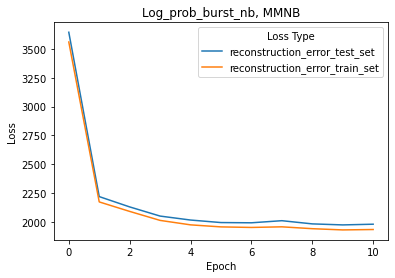

In [ ]:
runtime     = time.time() - start
memory_used = torch.cuda.memory_allocated()
results_dict[SETUP]['compute'].append([runtime,memory_used])

## Check train history
df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
              'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
df_history = pd.DataFrame(df_history)
df_history = pd.DataFrame(df_history.stack())
df = df_history
df.reset_index(inplace=True)
df.columns = ['Epoch','Loss Type', 'Loss']
figname = f"{SETUP}-{k}"
sns.lineplot(data=df, 
             x='Epoch', 
             y='Loss', 
             hue = 'Loss Type')
# plt.savefig(os.path.join(logdir_train,f"{figname}-train-history.pdf"))
# plt.close()
plt.title('Log_prob_burst_nb, MMNB');

In [ ]:
## Get reconstruction loss on test data
test_error  = model.get_reconstruction_error(test_adata)
train_error = model.get_reconstruction_error(train_adata)
results_dict[SETUP]['recon_error'].append(np.array([train_error,test_error]))

## Extract the embedding space for scVI
X_out = model.get_latent_representation(test_adata)

adata_latent = anndata.AnnData(X_out)
adata_latent.obs = test_adata.obs
results_dict[SETUP]['latent embedding'] = adata_latent
if datas == 'combined':
  test_adata_save = test_adata

INFO     Received view of anndata, making copy.                                                                    
INFO     Received view of anndata, making copy.                                                                    


In [ ]:
#### Validation with cluster accuracy based on labels
## Iterate through ground truth labels based on different approach

for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

    y = np.array(y.tolist())

    score_dict = calculate_accuracy(X_out,y)
    results_dict[SETUP][cluster_method].append(score_dict)

#### Get predicted distribution
if 'scBIVI' in method:

    params = model.get_likelihood_parameters(test_adata)
    mu = params['mean']
    if method == 'scBIVImixed':
        import torch.nn.functional as F
        mu,mw = np.split(mu,2,axis=1)
        mw_tensor = torch.tensor(mw.reshape(-1,int(mw.shape[1]/2),2))
        mw_softmax = F.softmax(mw_tensor/10e-20,dim=-1)

    mu1,mu2 = np.split(mu,2,axis=1)
    alpha = params['dispersions']

    if mu1.shape[1] == alpha.shape[1]:
        stats = {'mu1': mu1, 'mu2' : mu2,
                  '1/alpha'         : 1/alpha,
                  'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                  'mu2/alpha'       : mu2/alpha
                  }

        fig,axs = plt.subplots(1,len(stats),
                                figsize=(5*len(stats),4),
                                squeeze=False)

        for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
            ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
            ax.set_title(stat)

        # plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
        # plt.close()

#### Correlations

# cg = plot_corr_comparison(X1,X2)
# figname = f"{setup}-{k}"
# plt.title(figname)
# plt.savefig(os.path.join(logdir,f"{figname}-corr.pdf"))
# plt.close()

del model
torch.cuda.empty_cache()
gc.collect()


INFO     Received view of anndata, making copy.                                                                    


3073

here u go back and redefine `SETUPS`

Empty DataFrame
Columns: [Train, Test, Setup]
Index: []


ValueError: ignored

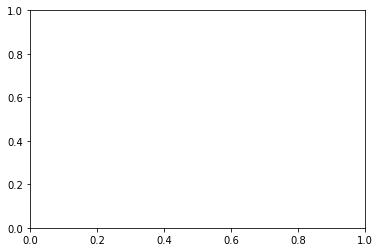

In [ ]:
#### Plot NLL
setups = list(results_dict.keys())
# df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error']),
#                                    "Test": -np.array(r['recon_error']),
#                                    'Setup': key}) for key,r in results_dict.items()])
df_plot = pd.concat([pd.DataFrame({"Train": -np.array(results_dict['scBIVIuncorr-10-combined']['recon_error']),
                                    "Test": -np.array(results_dict['scBIVIuncorr-10-combined']['recon_error']),
                                    'Setup': key}) for key,r in results_dict.items()])
print(df_plot)
df_plot['KFold'] = df_plot.index
df_plot.reset_index(drop=True)

df_plot.to_csv(os.path.join(logdir,'.svg'))

fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
# plt.savefig(os.path.join(logdir,'nll.svg'))
# plt.close()

#print(df_plot.groupby("Setup").mean())


ValueError: ignored

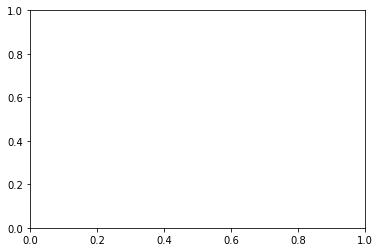

In [ ]:
#### Plot clustering accuracy

# iterate through different cluster methods
for cluster_method in cluster_methods:
    df_plot = pd.concat([pd.DataFrame(r[cluster_method]).assign(Setup=key) for key,r in results_dict.items()])
    df_plot.to_csv(os.path.join(logdir,f'clust_acc_{cluster_method}.csv'))
    df_plot = df_plot.melt(id_vars=['Setup'],var_name='Metric',value_name='Score')

    fig,ax=plt.subplots()
    _ = sns.barplot(data=df_plot, x='Metric', y='Score', hue='Setup', ax=ax)
    plt.xticks(rotation=45)
    # plt.savefig(os.path.join(logdir,f'clust_acc_{cluster_method}.svg'))
    # plt.close()
    print(df_plot)

# Loop through all K-folds split and setups

In [ ]:
print("{}/{}".format(torch.cuda.memory_allocated(),torch.cuda.max_memory_allocated()))

# Hyper-parameters
lr       = 1e-3
n_latent = 2
n_epochs = 10
n_hidden = 1024
n_layers = 3

#'scBIVIcustom-10-combined'
# setups = ['scBIVI-10-combined',
#           'scVI-10-combined',
#           "scVI-10-spliced",
#           'scVI-10-unspliced',
#           'scBIVIuncorr-10-combined',
#           'scBIVImixed-10-combined']
# setups = ['scBIVItemp_T=0.000001_Trate=0-10-combined']
setups = ['scBIVI-10-combined','scBIVIuncorr-10-combined']



cluster_methods = adata.obsm['Cluster'].columns.to_list()
metrics_list = ['recon_error','latent embedding','compute'] + cluster_methods
results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

logdir_train = os.path.join(logdir,'train')
os.makedirs(logdir_train, exist_ok=True)

1440652288/1583955456


In [ ]:
# train only one model
n_latent = 6
custom_dist = log_bursty_nb_bi_with_checks
    ## Set model parameters
model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
model_args.update(additional_kwargs)

model = sc.scBIVI(train_adata,mode='custom',**model_args)
model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs                                                                                  
Training...: 100%|██████████| 10/10 [00:20<00:00,  2.01s/it]
INFO     Training time:  11 s. / 10 epochs                                                                         


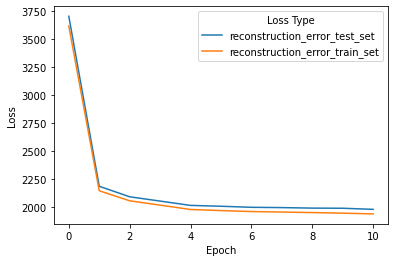

In [ ]:
df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
df_history = pd.DataFrame(df_history)
df_history = pd.DataFrame(df_history.stack())
df = df_history
df.reset_index(inplace=True)
df.columns = ['Epoch','Loss Type', 'Loss']
figname = f"{setup}-{k}"
sns.lineplot(data=df,x='Epoch', y='Loss', hue = 'Loss Type')
plt.show()

In [ ]:
params = model.get_likelihood_parameters(test_adata)
mu = params['mean']
mu1,mu2 = np.split(mu,2,axis=1)
alpha = params['dispersions']


print(test_adata)
print(mu1.shape)
print(alpha.shape)

INFO     Received view of anndata, making copy.                                                                    
View of AnnData object with n_obs × n_vars = 2316 × 5428
    obs: 'barcode', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var'
    var: 'gene_id', 'gene_name', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std', 'Spliced'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'umap', '_scvi'
    obsm: 'Cluster', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'
(2316, 2714)
(2316, 2714)


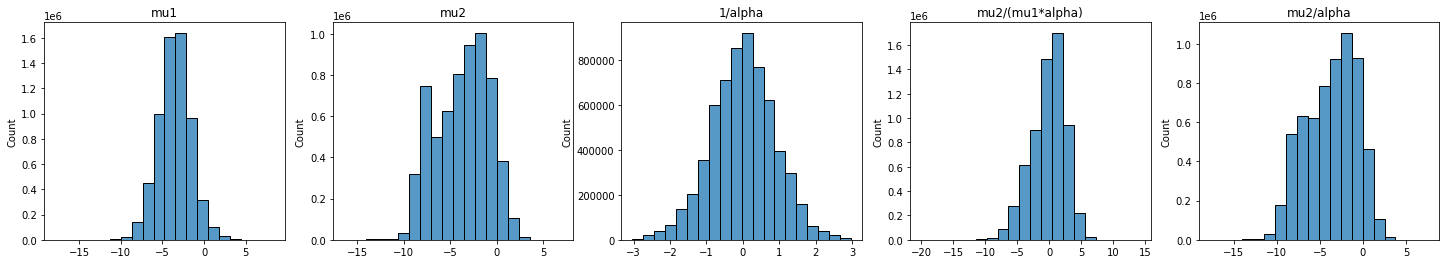

In [ ]:
if mu1.shape[1] == alpha.shape[1]:
            stats = {'mu1': mu1, 'mu2' : mu2,
                     '1/alpha'         : 1/alpha,
                     'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                     'mu2/alpha'       : mu2/alpha
                     }

fig,axs = plt.subplots(1,len(stats),
                                   figsize=(5*len(stats),4),
                                   squeeze=False)

for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
  ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
  ax.set_title(stat)

            #plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
plt.show()

In [ ]:
# for k, (train_index, test_index) in enumerate(skf_splits):
setups = ['scBIVI_MMNB-10-combined','scBIVI_nnNB-10-combined','scBIVI_direct-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]

results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}


NameError: ignored

In [ ]:
results_dict

In [ ]:
# for k, (train_index, test_index) in enumerate(skf_splits):
setups = ['scBIVI_MMNB-10-combined','scBIVI_nnNB-10-combined','scBIVI_direct-10-combined','scBIVI-10-combined','scBIVIuncorr-10-combined',]

results_dict = {setup:{metrics: [] for metrics in metrics_list} for setup in setups}

for q in range(1):
    #
  for setup in setups:
      #
    print(setup)
    method,n_latent,datas = setup.split("-")
    method_split = method.split('_')
    method = method_split[0]
    additional_kwargs = {s.split('=')[0]:float(s.split('=')[1]) for s in method_split[1:]}

    n_latent = int(n_latent)

    ## Split the data
    if datas == 'spliced':
      adata_in = adata[:,:int(adata.shape[1]/2)]
    elif datas == 'unspliced':
      adata_in = adata[:,int(adata.shape[1]/2):]
    elif datas == 'combined':
      adata_in = adata
    else:
      raise ValueError("Input valid datas")

    adata_in = adata_in.copy()
    scvi.data.setup_anndata(adata_in, layer="counts")

    train_adata, test_adata = adata_in[train_index], adata_in[test_index]
    train_adata = train_adata.copy()

    ## Set model parameters
    model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
    model_args.update(additional_kwargs)

    ## Create model
    if method == 'LDVAE':
        model = scvi.model.LinearSCVI(train_adata,**model_args)
    elif method == 'scVI':
        model = scvi.model.SCVI(train_adata,**model_args)
    elif method == "scBIVI":
        model = scBIVI(train_adata,mode='corr',**model_args)
    elif method == "scBIVIuncorr":
        model = scBIVI(train_adata,mode='uncorr',**model_args)
    elif method == 'scBIVImixed':
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVItemp':
        # model_args['T'] = 1
        # model_args['Trate'] = 1
        model = scBIVI(train_adata,mode='mixed',**model_args)
    elif method == 'scBIVIcustom1':
        custom_dist = log_bursty_nb_bi_with_checks
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'scBIVIcustom2':
        custom_dist = log_prob_direct1
        model = scBIVI(train_adata,mode='custom',**model_args)
    elif method == 'scBIVIcustom3':
        custom_dist = log_prob_direct2
        model = scBIVI(train_adata,mode='custom',**model_args)
    else:
        raise Exception('Input valid scVI model')

    ## Train model
    start = time.time()
    model.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

    runtime     = time.time() - start
    memory_used = torch.cuda.memory_allocated()
    results_dict[setup]['compute'].append([runtime,memory_used])

    ## Check train history
    df_history = {'reconstruction_error_test_set' : model.history['reconstruction_error_test_set'],
                  'reconstruction_error_train_set': model.history['reconstruction_error_train_set']}
    df_history = pd.DataFrame(df_history)
    df_history = pd.DataFrame(df_history.stack())
    df = df_history
    df.reset_index(inplace=True)
    df.columns = ['Epoch','Loss Type', 'Loss']
    figname = f"{setup}-{k}"
    sns.lineplot(data=df,x='Epoch', y='Loss', hue = 'Loss Type')
    plt.show()
    #plt.savefig(os.path.join(logdir_train,f"{figname}-train-history.pdf"))
    plt.close()

    ## Get reconstruction loss on test data
    test_error  = model.get_reconstruction_error(test_adata)
    train_error = model.get_reconstruction_error(train_adata)
    results_dict[setup]['recon_error'].append(np.array([train_error,test_error]))

    ## Extract the embedding space for scVI
    X_out = model.get_latent_representation(test_adata)

    if k == 0:
      adata_latent = anndata.AnnData(X_out)
      adata_latent.obs = test_adata.obs
      results_dict[setup]['latent embedding'] = adata_latent
      if datas == 'combined':
        test_adata_save = test_adata

    #### Validation with cluster accuracy based on labels
    ## Iterate through ground truth labels based on different approach

    for cluster_method, y in test_adata.obsm['Cluster'].iteritems():

        y = np.array(y.tolist())

        score_dict = calculate_accuracy(X_out,y)
        results_dict[setup][cluster_method].append(score_dict)

    #### Get predicted distribution
    if 'scBIVI' in method:

        params = model.get_likelihood_parameters(test_adata)
        mu = params['mean']
        if method == 'scBIVImixed':
            import torch.nn.functional as F
            mu,mw = np.split(mu,2,axis=1)
            mw_tensor = torch.tensor(mw.reshape(-1,int(mw.shape[1]/2),2))
            mw_softmax = F.softmax(mw_tensor/10e-20,dim=-1)

        mu1,mu2 = np.split(mu,2,axis=1)
        alpha = params['dispersions']

        if mu1.shape[1] == alpha.shape[1]:
            stats = {'mu1': mu1, 'mu2' : mu2,
                     '1/alpha'         : 1/alpha,
                     'mu2/(mu1*alpha)' : mu2/(mu1*alpha),
                     'mu2/alpha'       : mu2/alpha
                     }

            fig,axs = plt.subplots(1,len(stats),
                                   figsize=(5*len(stats),4),
                                   squeeze=False)

            for ax, (stat,x) in zip(axs.reshape(-1),stats.items()):
                ax = sns.histplot(np.log(x.reshape(-1)),kde=False,ax=ax,bins=20)
                ax.set_title(stat)

            #plt.savefig(os.path.join(logdir_train,f"{figname}-hist.pdf"))
            plt.show()
            plt.close()

    #### Correlations

    # cg = plot_corr_comparison(X1,X2)
    # figname = f"{setup}-{k}"
    # plt.title(figname)
    # plt.savefig(os.path.join(logdir,f"{figname}-corr.pdf"))
    # plt.close()

    del model
    torch.cuda.empty_cache()
    gc.collect()


scBIVIcustom1-10-combined
INFO     No batch_key inputted, assuming all cells are same batch                                                  
INFO     No label_key inputted, assuming all cells have same label                                                 
INFO     Using data from adata.layers["counts"]                                                                    
INFO     Computing library size prior per batch                                                                    
INFO     Successfully registered anndata object containing 11581 cells, 5428 vars, 1 batches, 1 labels, and 0      
         proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.               
INFO     Please do not further modify adata until model is trained.                                                
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs             

More stuff

In [ ]:
custom_dist = log_bursty_nb_bi_with_checks

In [ ]:
#### Plot NLL
setups = list(results_dict.keys())
df_plot = pd.concat([pd.DataFrame({"Train": -np.array(r['recon_error'])[:,0],
                                   "Test": -np.array(r['recon_error'])[:,1],
                                   'Setup': key}) for key,r in results_dict.items()])

df_plot['KFold'] = df_plot.index
df_plot.reset_index(drop=True)

df_plot.to_csv(os.path.join(logdir,'.svg'))

fig,ax=plt.subplots()
_ = sns.barplot(data=df_plot, x='Setup', y='Test', hue='Setup', dodge=False, ax=ax)
ax.get_legend().remove()
plt.xticks(rotation=45)
# plt.savefig(os.path.join(logdir,'nll.svg'))
# plt.close()

print(df_plot.groupby("Setup").mean())


                                 Train         Test  KFold
Setup                                                     
scBIVI-10-combined         1932.637948  1938.991413    0.0
scBIVIcustom1-10-combined  1935.954022  1943.310269    0.0
scBIVIcustom2-10-combined  1927.757219  1937.322537    0.0
scBIVIcustom3-10-combined  1928.968632  1938.413388    0.0
scBIVIuncorr-10-combined   1920.151434  1929.242677    0.0


ImportError: ignored

<Figure size 320x320 with 1 Axes>

In [ ]:
#### Plot clustering accuracy

# iterate through different cluster methods
for cluster_method in cluster_methods:
    df_plot = pd.concat([pd.DataFrame(r[cluster_method]).assign(Setup=key) for key,r in results_dict.items()])
    df_plot.to_csv(os.path.join(logdir,f'clust_acc_{cluster_method}.csv'))
    df_plot = df_plot.melt(id_vars=['Setup'],var_name='Metric',value_name='Score')

    fig,ax=plt.subplots()
    _ = sns.barplot(data=df_plot, x='Metric', y='Score', hue='Setup', ax=ax)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xticks(rotation=45)
    # plt.savefig(os.path.join(logdir,f'clust_acc_{cluster_method}.svg'))
    # plt.close()
    print(df_plot)

                        Setup      Metric     Score
0   scBIVIcustom1-10-combined         ARI  0.688735
1   scBIVIcustom2-10-combined         ARI  0.698148
2   scBIVIcustom3-10-combined         ARI  0.669173
3          scBIVI-10-combined         ARI  0.671235
4    scBIVIuncorr-10-combined         ARI  0.714984
5   scBIVIcustom1-10-combined         NMI  0.809445
6   scBIVIcustom2-10-combined         NMI  0.808472
7   scBIVIcustom3-10-combined         NMI  0.805097
8          scBIVI-10-combined         NMI  0.801719
9    scBIVIuncorr-10-combined         NMI  0.822616
10  scBIVIcustom1-10-combined  silhouette  0.157861
11  scBIVIcustom2-10-combined  silhouette  0.153975
12  scBIVIcustom3-10-combined  silhouette  0.161558
13         scBIVI-10-combined  silhouette  0.174686
14   scBIVIuncorr-10-combined  silhouette  0.167481


ImportError: ignored

<Figure size 320x320 with 1 Axes>

----


# Define DIRECT Model


Just to make sure that it can work with another neural network. Plus to check the GPU usage of the direct model. 


Later models will be addressed later. 
 




In [ ]:

import sys
sys.path.insert(0,'/content/drive/My Drive/scBIVI_mc/scBIVI/')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from scipy import stats

In [ ]:
# define model to load in 
# define model

class direct_MLP(nn.Module):

    def __init__(self, input_size, num_hidden_units, num_hidden_layers, output_size,activate='relu'):
    	super().__init__()
    	self.activate = activate
    	self.module_list = nn.ModuleList([])
    	self.module_list.append(nn.Linear(input_size,num_hidden_units))


    	for k in range(num_hidden_layers-1):
    		self.module_list.append(nn.Linear(num_hidden_units, num_hidden_units))


    	self.module_list.append(nn.Linear(num_hidden_units,output_size))


    def forward(self, x):

    	for f in self.module_list[:-1]:

    		x = f(x)

    		if self.activate == 'relu':
    			x = F.relu(x)
    		elif self.activate == 'sigmoid':
    			x = F.sigmoid(x)

    	x = self.module_list[-1](x)

    	return x



In [ ]:

model_path1 = '/content/drive/My Drive/scBIVI_mc/scBIVI/models/256hidu_2hidl_MODEL'  
model_path2 = '/content/drive/My Drive/scBIVI_mc/scBIVI/models/256hidu_3hidl_MODEL' 

# load in model1
model_direct1 = direct_MLP(input_size=5, num_hidden_units=256, num_hidden_layers=2, output_size= 1, activate='relu')
model_direct1.load_state_dict(torch.load(model_path1))
model_direct1.eval()     
model_direct1.to(torch.device('cuda'))

# load in model2
model_direct2 = direct_MLP(input_size=5, num_hidden_units=256, num_hidden_layers=3, output_size= 1, activate='relu')
model_direct2.load_state_dict(torch.load(model_path2))
model_direct2.eval()     
model_direct2.to(torch.device('cuda'))

direct_MLP(
  (module_list): ModuleList(
    (0): Linear(in_features=5, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [ ]:
def log_prob_direct1(x: torch.tensor, mu1: torch.tensor, mu2: torch.tensor,
                       theta: torch.tensor, eps, model_version = 1):
    
    
    ''' 
    x : anndata object containing unspliced/spliced RNA
    
    mu1 : mean of nascent RNA (output from DecoderSCVI)
    
    mu2 : mean of mature RNA (output from DecoderSCVI)
    
    theta : shape parameter (NAS or MAT shape , correlation)? 
        -- how to interpret physically ? 
        
    Takes output from SCVI model and calculates the probability of data given the bursty, two-species model of transcription.
    Uses DIRECT model.
    '''
    if model_version ==  2:
      model = model_direct2
    else:
      model = model_direct2

    # Divide the original data x into spliced (x) and unspliced (y)
    n,m = torch.chunk(x,2,dim=-1)
    
    # calculate parameter vectors
    THETA_IS_MAT_SHAPE = False #best performance: breaks at 65%
    THETA_IS_B = False
    THETA_IS_NAS_SHAPE = True

    if THETA_IS_MAT_SHAPE:
        gamma = 1/theta
        b = mu2*gamma
        beta = b/mu1
    elif THETA_IS_B:
        b = theta
        beta = b/mu1
        gamma = b/mu2
    elif THETA_IS_NAS_SHAPE:
        beta = 1/theta
        b = mu1*beta
        gamma = b/mu2


    # take log and reshape to feed through model
    b_log = torch.log(b).reshape(-1,1)
    beta_log = torch.log(beta).reshape(-1,1)
    gamma_log = torch.log(gamma).reshape(-1,1)

    rate_vectors = torch.column_stack((b_log,beta_log,gamma_log,n.reshape(-1,1),m.reshape(-1,1)))


    # feed rate vectors through model to get weights and hyperparameter
    probabilities = model(rate_vectors)
    print(torch.max(probabilities))
    
    return(probabilities.reshape(theta.shape))


log_prob_direct2 = lambda x, mu1, mu2, theta, eps: log_prob_direct1(x, mu1, mu2, theta, eps, model_version = 2)

-----


#Clustering: Latent Space



Visualize latent space UMAPs vs. UMAP of full data, top two PCA components of full data, top two PCA components of just nRNA, top two PCA components of just mRNA, UMAP of top 30 PCA components (for example)...




First, train four models: 
1. Vanilla Bivariate NB
2. Uncorrelated Bivariate NB
3. MMNB
4. Direct 


In [ ]:
# train four models
n_latent = 3


    ## Set model parameters
model_args = {'use_cuda'     : True,
                  'n_latent'     : n_latent,
                  'n_layers'     : n_layers,
                  'dispersion'   : 'gene',
                  'n_hidden'     : n_hidden,
                  'dropout_rate' :  0.1,
                  'gene_likelihood'    :  'nb',
                  'log_variational'    :  True,
                  'latent_distribution':  'normal'
                  }
model_args.update(additional_kwargs)


# train vanilla bivariate NB
model_corr = scBIVI(train_adata,mode='corr',**model_args)
model_corr.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)



# train uncorrelated NB
model_uncorr = scBIVI(train_adata,mode='uncorr',**model_args)
model_uncorr.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)



# train MMNB
custom_dist = log_bursty_nb_bi_with_checks
model_MMNB = scBIVI(train_adata,mode='custom',**model_args)
model_MMNB.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)



# train direct
custom_dist = log_prob_direct1
model_direct = scBIVI(train_adata,mode='custom',**model_args)
model_direct.train(n_epochs = n_epochs,
                lr       = lr,
                n_epochs_kl_warmup = n_epochs/2,
                metrics_to_monitor = ['reconstruction_error'],
                frequency = 1,
                train_size = 0.9)

INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs                                                                                  
Training...: 100%|██████████| 10/10 [00:22<00:00,  2.21s/it]
INFO     Training time:  11 s. / 10 epochs                                                                         
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs                                                                                  
Training...: 100%|██████████| 10/10 [00:19<00:00,  1.95s/it]
INFO     Training time:  10 s. / 10 epochs                                                                         
INFO     Training for 10 epochs                                                                                    
INFO     KL warmup for 5.0 epochs                                 

In [ ]:
# get latent spaces for various models

# register data with scVI

# get z vectors
latent_corr = model_corr.get_latent_representation(adata)
latent_uncorr = model_uncorr.get_latent_representation(adata)
latent_MMNB = model_MMNB.get_latent_representation(adata)
latent_direct = model_direct.get_latent_representation(adata)


# store the z vectors in the adata object
adata.obsm["X_corr"] = latent_corr
adata.obsm["X_uncorr"] = latent_uncorr
adata.obsm["X_MMNB"] = latent_MMNB
adata.obsm["X_direct"] = latent_direct

In [ ]:
len(adata.obsm["X_corr"])

11581

# Inspect Data


How have the cell types or clusters been assigned? 
How many cell types are there? 

In [ ]:
import scanpy as sc
sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.obs["Cluster"] = adata.obsm["Cluster"]["RNA_leiden"]

## UMAP 

Z=3, CORR


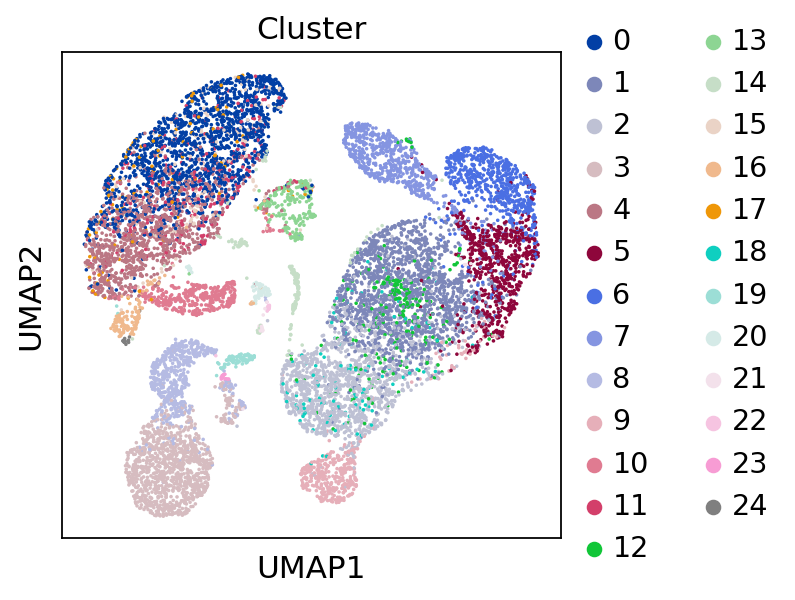

In [ ]:
sc.pp.neighbors(adata, use_rep="X_corr")
sc.tl.umap(adata)
print('Z=3, CORR')
sc.pl.umap(adata,
           color="Cluster")


Z=3, UNCORR


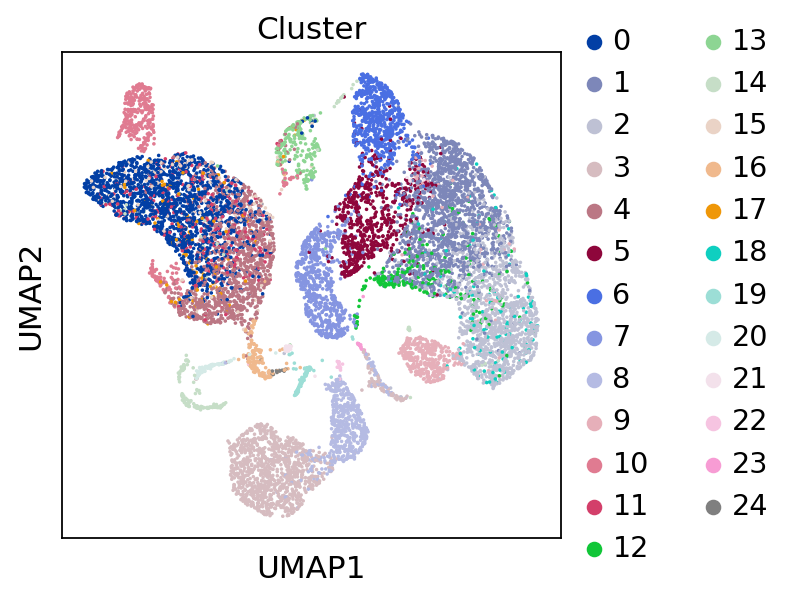

In [ ]:
# NOW, uncorrelated
sc.pp.neighbors(adata, use_rep="X_uncorr")
sc.tl.umap(adata)
print("Z=3, UNCORR")
sc.pl.umap(adata,
           color="Cluster")

Z=3, MMNB


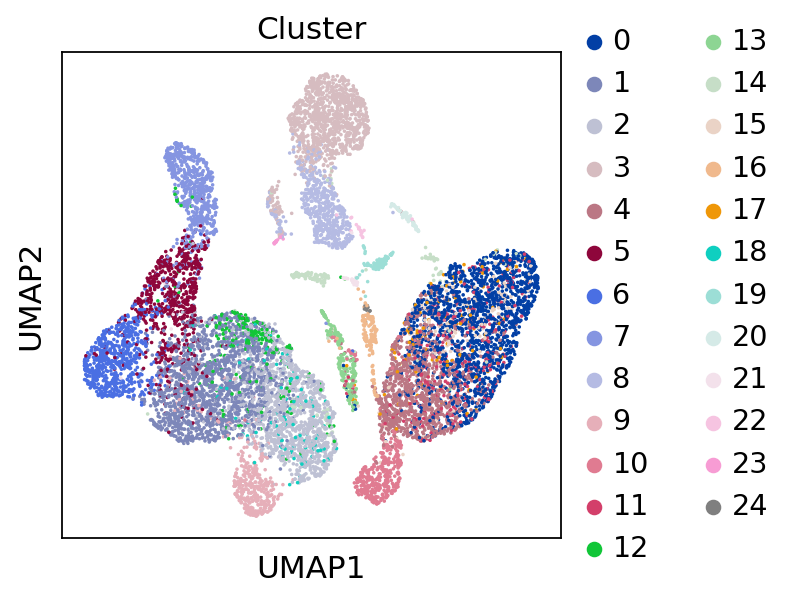

In [ ]:
# NOW, MMNB
sc.pp.neighbors(adata, use_rep="X_MMNB")
sc.tl.umap(adata)
print('Z=3, MMNB')
sc.pl.umap(adata,
           color="Cluster")

Z=3, DIRECT


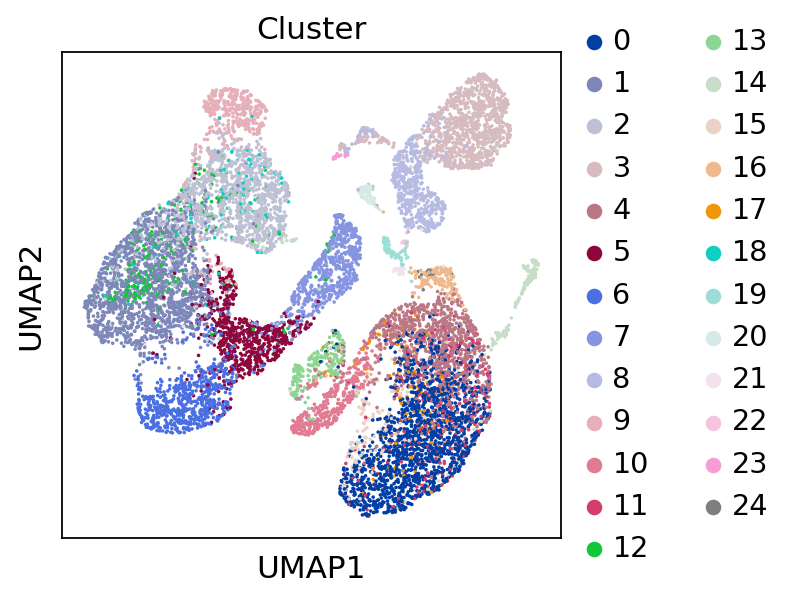

In [ ]:
# and finally, DIRECT method
sc.pp.neighbors(adata, use_rep="X_direct")
sc.tl.umap(adata)
print("Z=3, DIRECT")
sc.pl.umap(adata,
           color="Cluster")

In [ ]:
# Top 40 PCA components! 
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=40, n_neighbors=10)
sc.tl.umap(adata)

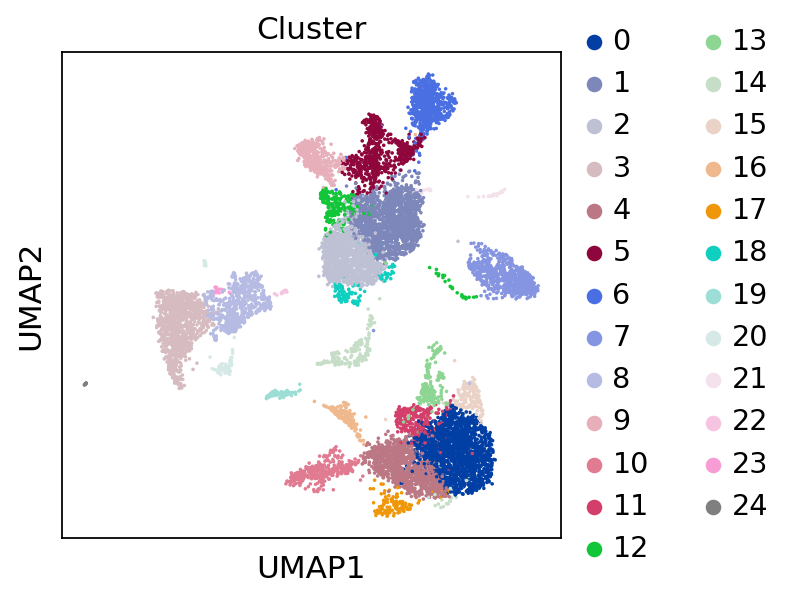

In [ ]:
sc.pl.umap(adata,
           color="Cluster")

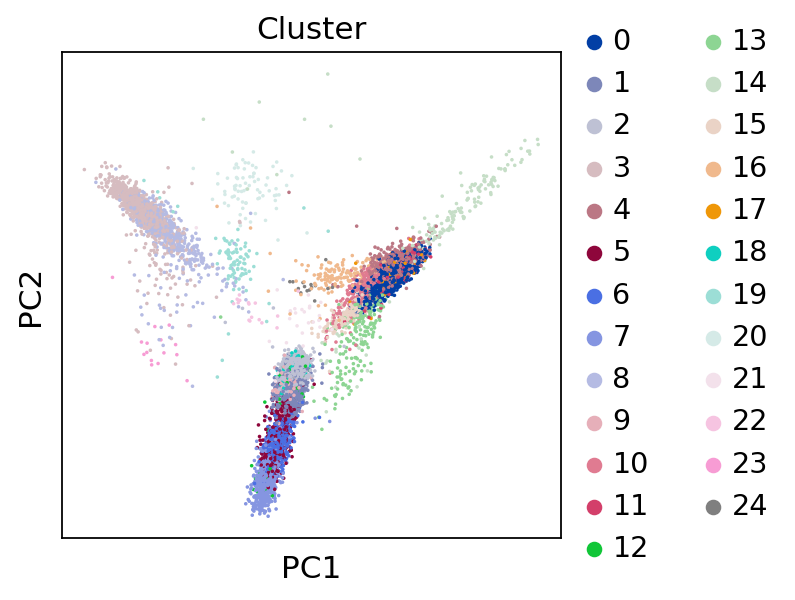

In [ ]:
sc.pl.pca(adata,components=['1,2'],color='Cluster')

-----

# Comparisons
## Comparing Models, Latent Spaces, and Constant Assumption


Models:
1. Correlated bivariate NB
2. Uncorrelated univariate NBs
3. Bursty, MMNB
4. Bursty, Direct Regression


3 Assumptions:
1. Shape of Nascent RNA is constant ($\theta = 1/\beta$)
2. Shape of Mature RNA is constant ($\theta = 1/\gamma$)
3. Burst size is constant ($\theta = b$)

With z = 3, 6, and 10 (latent dimensions). 

In [ ]:
nas_shape = {
    'corr' : {'RE' : [1947.665310,1946.874350,1943.581728],
             'ARI' : [0.619005,0.682639,0.671235],
             'NMI' : [0.774543,0.801377,0.801719],
              'Silhouette' : [0.212571,0.187780,0.174686]},
     'MMNB' : {'RE' : [1957.785199,1942.747160,1945.647343],
             'ARI' : [0.683074,0.691504,0.688073],
             'NMI' : [0.792718,0.804758,0.809445],
              'Silhouette' : [0.202597,0.195263,0.157861]},
     'Direct 1' : {'RE' : [1950.198082,1939.811088,1942.189209],
             'ARI' : [0.660513,0.686133,0.698148],
             'NMI' : [0.793987,0.807011,0.808472],
              'Silhouette' : [0.205648,0.214588,0.153975]},
     'Direct 2' : {'RE' : [1954.433166,1946.615324,1942.924174],
             'ARI' : [0.647239,0.711788,0.669173],
             'NMI' : [0.781008,0.813400,0.805097],
              'Silhouette' : [0.215235,0.193919,0.161558]},
     'uncorr' : {'RE' : [1951.078280,1932.484544,1936.985370],
             'ARI' : [0.649067,0.672554,0.714984],
             'NMI' : [0.790376,0.802166,0.822616],
              'Silhouette' : [0.222948,0.204844,0.167481]}              
              }
              
mat_shape = {
     'MMNB' : {'RE' : [1947.856589,1950.718136,1946.286222],
             'ARI' : [0.620858,0.701511,0.678496],
             'NMI' : [0.764246,0.810901,0.809378],
              'Silhouette' : [0.225922,0.189721,0.214231]},
     'Direct 1' : {'RE' : [1958.49481,1939.188158,1945.443118],
             'ARI' : [0.616254,0.697728,0.714594],
             'NMI' : [0.771819,0.817467,0.823445],
              'Silhouette' : [0.200540,0.171888,0.177146]},
     'Direct 2' : {'RE' : [1954.424953,1946.247707,1944.986875],
             'ARI' : [0.652605,0.678793,0.688768],
             'NMI' : [0.783754,0.799904,0.810318],
              'Silhouette' : [0.232678,0.181740,0.179190]},
    'corr' : {'RE' : [1952.116452,1943.316506,1940.837278],
             'ARI' : [0.689752,0.669609,0.708711],
             'NMI' : [0.798351,0.800616,0.816054],
              'Silhouette' : [0.222333,0.187423,0.173714]},
     'uncorr' : {'RE' : [1934.106931,1939.241583,1937.078094],
             'ARI' : [0.658082,0.688794,0.703527],
             'NMI' : [0.797208,0.809470,0.814056],
              'Silhouette' : [0.230656,0.209277,0.202571]}             
              }

b_shape = {
     'MMNB' : {'RE' : [1959.060403,1948.332427,1945.273110],
             'ARI' : [0.654013,0.679455,0.696669],
             'NMI' : [0.790649,0.802051,0.809574],
              'Silhouette' : [0.218833,0.193132,0.189267]},
     'Direct 1' : {'RE' : [1948.980865,1945.390556,1946.003827],
             'ARI' : [0.640107,0.653827,0.689719],
             'NMI' : [0.785183,0.794796,0.809368],
              'Silhouette' : [0.210126,0.192325,0.191142]},
     'Direct 2' : {'RE' : [1946.557750,1942.894057,1947.289867],
             'ARI' : [0.641500,0.657163,0.688162],
             'NMI' : [0.779642,0.791901,0.815108],
              'Silhouette' : [0.230636,0.179491,0.196279]},
     'corr' : {'RE' : [1947.748519,1948.790090,1945.529595],
             'ARI' : [0.634151,0.644233,0.698200],
             'NMI' : [0.777295,0.789348,0.812338,],
              'Silhouette' : [0.207366,0.177536,0.190684]},
     'uncorr' : {'RE' : [1941.894017,1929.900241,1936.869292],
             'ARI' : [0.658498,0.732725,0.672847],
             'NMI' : [0.796113,0.831536,0.802620],
              'Silhouette' : [0.237133,0.198097,0.198496]}              
              }          

In [ ]:
import matplotlib.pyplot as plt

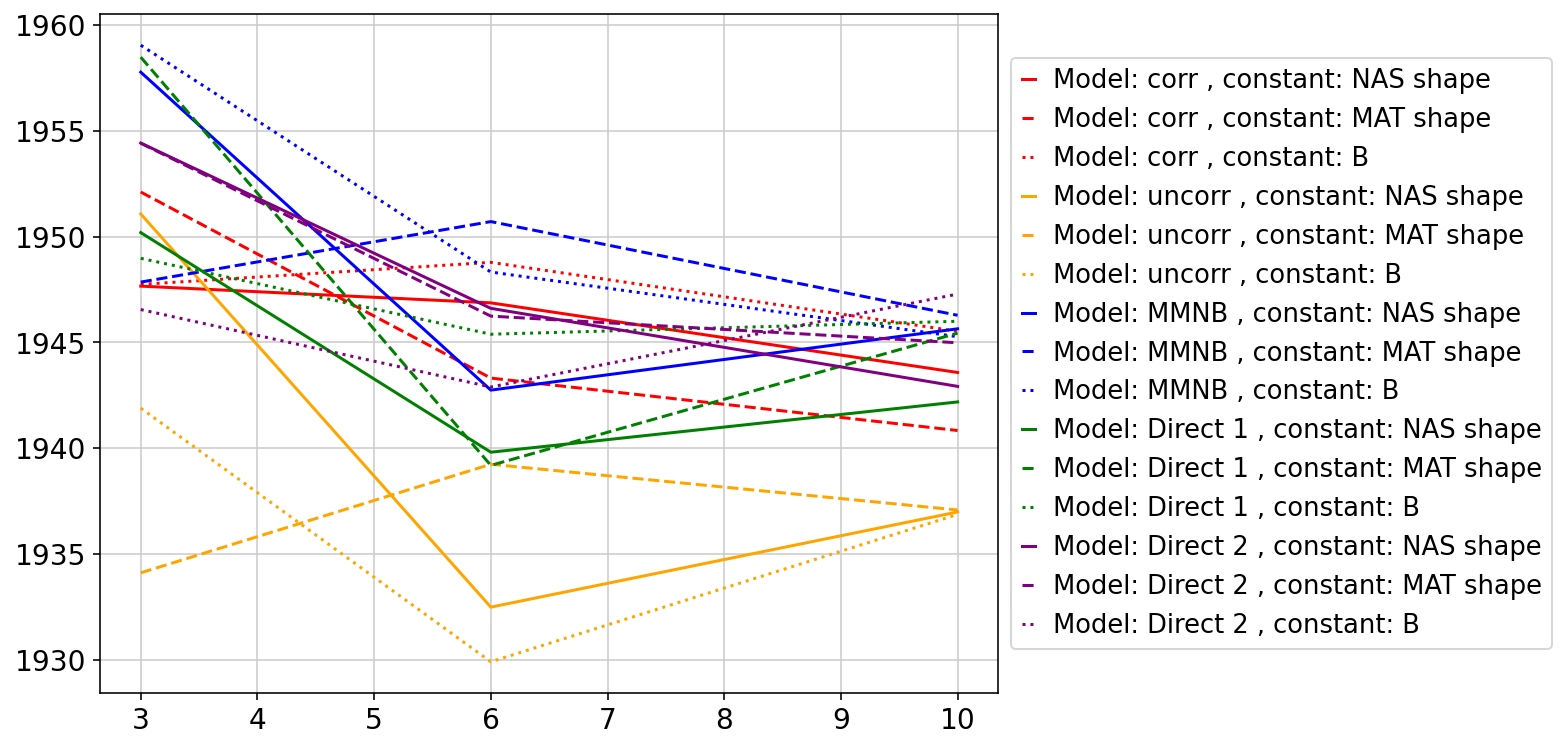

In [ ]:
zs = [3,6,10]

models = ['corr','uncorr','MMNB','Direct 1','Direct 2']

metric = ['RE','ARI','NMI','Silhouette']

colors = {'corr' : 'red', 'uncorr' : 'orange', 'MMNB' : 'blue' , 'Direct 1': 'green', 'Direct 2' : 'purple' }



plt.figure(figsize=(8, 6))

for model in models:

  plt.plot(zs,nas_shape[model]['RE'],color= colors[model],linestyle = 'solid',label=' Model: '+model +' , constant: NAS shape') 
  plt.plot(zs,mat_shape[model]['RE'],color= colors[model],linestyle = 'dashed',label=' Model: '+model +' , constant: MAT shape')
  plt.plot(zs,b_shape[model]['RE'],color= colors[model],linestyle = 'dotted',label=' Model: '+model +' , constant: B')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [ ]:
zs = [3,6,10]

models = ['corr','uncorr','MMNB','Direct 1','Direct 2']

metric = ['RE','ARI','NMI','Silhouette']

colors = {'corr' : 'red', 'uncorr' : 'orange', 'MMNB' : 'blue' , 'Direct 1': 'green', 'Direct 2' : 'purple' }



plt.figure(figsize=(8, 6))

for model in models:

  plt.scatter(zs,nas_shape[model]['RE'],color= colors[model],marker = 'o',label=' Model: '+model +' , constant: NAS shape') 
  plt.scatter(zs,mat_shape[model]['RE'],color= colors[model],marker = '*',label=' Model: '+model +' , constant: MAT shape')
  plt.scatter(zs,b_shape[model]['RE'],color= colors[model],marker = '^',label=' Model: '+model +' , constant: B')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Testing Reconstruction Loss versus Z-dimension')
plt.xlabel('Z dimension (nodes)')
plt.ylabel('Testing Reconstruction Loss')

NameError: ignored

Text(0, 0.5, 'Clustering Efficiency (ARI)')

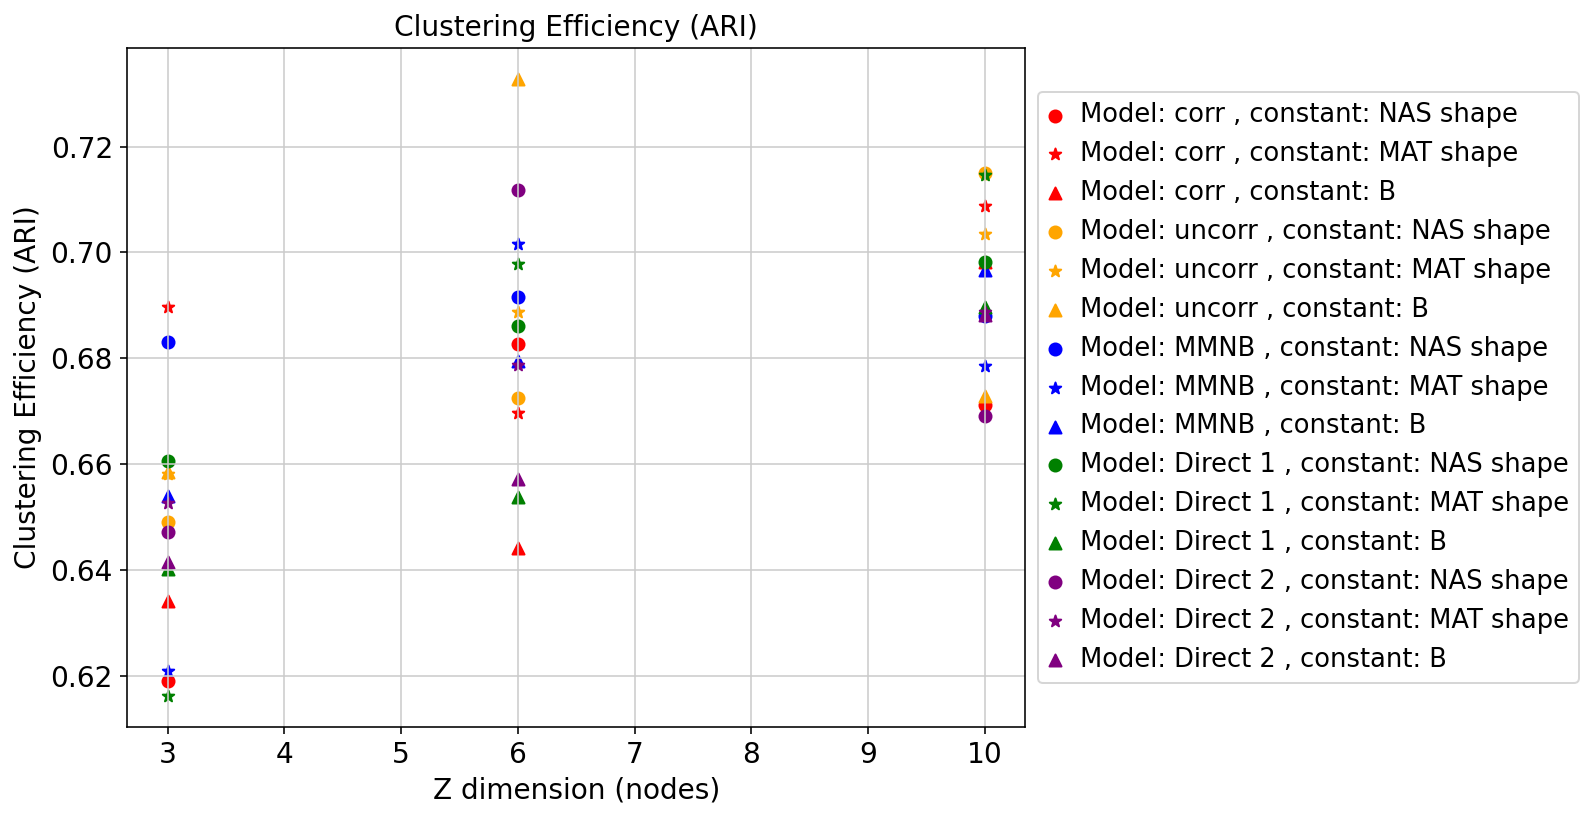

In [ ]:

plt.figure(figsize=(8, 6))

for model in models:

  plt.scatter(zs,nas_shape[model]['ARI'],color= colors[model],marker = 'o',label=' Model: '+model +' , constant: NAS shape') 
  plt.scatter(zs,mat_shape[model]['ARI'],color= colors[model],marker = '*',label=' Model: '+model +' , constant: MAT shape')
  plt.scatter(zs,b_shape[model]['ARI'],color= colors[model],marker = '^',label=' Model: '+model +' , constant: B')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Clustering Efficiency (ARI)')
plt.xlabel('Z dimension (nodes)')
plt.ylabel('Clustering Efficiency (ARI)')

In [ ]:
fig,axs = plt.subplots(1,3,figsize=(8, 6)))

for model in models:

  ax[0,i].scatter(zs,nas_shape[model][''],color= colors[model],marker = 'o',label=' Model: '+model +' , constant: NAS shape') 
  ax[0,i].scatter(zs,mat_shape[model]['ARI'],color= colors[model],marker = '*',label=' Model: '+model +' , constant: MAT shape')
  ax[0,i].scatter(zs,b_shape[model]['ARI'],color= colors[model],marker = '^',label=' Model: '+model +' , constant: B')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Clustering Efficiency (ARI)')
plt.xlabel('Z dimension (nodes)')
plt.ylabel('Clustering Efficiency (ARI)')